# Предсказание следующей покупки в течении следующих 30 дней.

<img src="https://marketoonist.com/wp-content/uploads/2024/02/240212.n.search.jpg" width="500" align="right"/> Удержание клиентов имеет решающее значение для успеха на жестоком рынке. Удержание текущих потребителей более рентабельно, чем приобретение новых.

Удержание клиентов приводит к появлению преданной клиентуры, увеличению доходов и долгосрочной прибыльности. Однако ряд факторов, в том числе экономические условия, конкуренция и тенденции моды, затрудняют прогнозирование поведения и предпочтений клиентов. 

Предприятиям необходимы сложные возможности машинного обучения и анализа данных для анализа потребительских данных и составления точных прогнозов для решения этих проблем. 

Предприятия могут корректировать маркетинговые усилия, улучшать качество обслуживания клиентов и повышать уровень счастья, предвидя следующие покупки своих потребителей, что в конечном итоге повысит их удержание и лояльность.

## Настройка проекта.

### Импорт библиотек, модулей, классов и функций.

In [1]:
import os
from pathlib import Path
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

### Настройка окружения и глобальные переменные.

In [2]:
RANDOM_STATE = 42

In [3]:
plt.style.use('default')

### Пользовательские функции.

In [4]:
def my_analyze_classification_performance(model=None, dummy=None, target=None, features=None):
    '''
    Функция предназначена для анализа производительности моделей классификации,
    включая построение ROC-кривой и кривой точности и полноты.
    Она также поддерживает сравнение с dummy моделью, если она предоставлена.
    '''
        
    # Получаем имя модели (закомментированная строка с оригинальной версии кода)
    model_name = 'CatBoostClassifier'  #model.__class__.__name

    # Вычисляем вероятности прогнозов целевой переменной
    target_train_pred_prob = model.predict_proba(features)[:, 1]
    
    # Вычисляем ROC-кривую и AUC-ROC
    fpr, tpr, thresholds = roc_curve(target, target_train_pred_prob)
    auc_roc = roc_auc_score(target, target_train_pred_prob)

    # Если есть dummy модель, то вычисляем ее вероятности и метрики ROC и AUC
    if dummy is not None:
        target_train_pred_prob_dummy = dummy.predict_proba(features)[:, 1]
        fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(target, target_train_pred_prob_dummy)
        auc_roc_dummy = roc_auc_score(target, target_train_pred_prob_dummy)

    # Создаем график с двумя подграфиками
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f'Производительность модели классификации {model_name}')

    # График ROC-кривой
    ax[0].plot(fpr, tpr, color='SteelBlue', label='ROC Curve')
    if dummy is not None:
        ax[0].plot(fpr_dummy, tpr_dummy, '--', color='DarkRed', label=('Dummy ' + dummy.strategy))
    else:
        ax[0].plot([0, 1], [0, 1], '--', color='DarkRed', label='Random Guess')
    ax[0].legend(loc='lower right')
    if dummy is not None:
        ax[0].set_title(f'ROC curve (AUC = {auc_roc:.3f})\nDummy {dummy.strategy} AUC = {auc_roc_dummy:.3f}')
    else:
        ax[0].set_title(f'ROC curve (AUC = {auc_roc:.3f})')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].grid(True)

    # График кривой точности и полноты
    precision, recall, thresholds = precision_recall_curve(target, target_train_pred_prob)
    auc_pr = average_precision_score(target, target_train_pred_prob)

    # Если есть dummy модель, то вычисляем ее кривую точности и полноты, а также AUC
    if dummy is not None:
        precision_dummy, recall_dummy, thresholds_dummy = precision_recall_curve(target, target_train_pred_prob_dummy)
        auc_pr_dummy = average_precision_score(target, target_train_pred_prob_dummy)

    ax[1].plot(recall, precision, color='SteelBlue', label='Precision-Recall Curve')
    if dummy is not None:
        ax[1].plot(recall_dummy, precision_dummy, '--', color='DarkRed', label=('Dummy ' + dummy.strategy))
    else:
        ax[1].plot([0, 1], [1, 0], '--', color='DarkRed', label='Random Guess')
    ax[1].legend(loc='lower left')
    if dummy is not None:
        ax[1].set_title(f'Precision-Recall curve (AUC = {auc_pr:.3f})\nDummy {dummy.strategy} AUC = {auc_pr_dummy:.3f}')
    else:
        ax[1].set_title(f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].grid(True)

    # Отображаем графики
    plt.tight_layout()
    plt.show()

## Загрузка данных.

In [5]:
gifts_purchases = pd.read_csv(
    r'data\gifts-purchases.csv',
    parse_dates=['date', 'date'],
    dtype={'client_id': 'object'},
)

### Анализ.

In [6]:
gifts_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       811 non-null    object        
 1   quantity        811 non-null    int64         
 2   price           811 non-null    float64       
 3   date            811 non-null    datetime64[ns]
 4   message_id      811 non-null    object        
 5   recommended_by  811 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 38.1+ KB


In [7]:
gifts_purchases.head()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


In [8]:
gifts_purchases.describe(include='all')

,client_id,quantity,price,date,message_id,recommended_by
count,811,811.000000,811.000000,811,811,811
unique,326,NaN,NaN,NaN,342,1
top,1515915625803894158,NaN,NaN,NaN,1515915625935652010-16166-6525589bca68f,bulk_message
freq,49,NaN,NaN,NaN,22,811
mean,NaN,1.003699,14468.795314,2023-04-27 23:45:47.718865664,NaN,NaN
min,NaN,1.000000,656.000000,2022-10-26 00:00:00,NaN,NaN
25%,NaN,1.000000,3878.000000,2023-01-31 00:00:00,NaN,NaN
50%,NaN,1.000000,7533.000000,2023-05-22 00:00:00,NaN,NaN
75%,NaN,1.000000,17938.000000,2023-07-12 00:00:00,NaN,NaN
max,NaN,2.000000,173586.000000,2023-10-24 00:00:00,NaN,NaN


### Удаление неинформативтивных признаков.

In [9]:
gifts_purchases.drop(['message_id', 'recommended_by'], axis=1, inplace=True)

### Сортировка данных.

In [10]:
gifts_purchases = gifts_purchases.sort_values(
    by=['date', 'client_id']
).reset_index(drop=True)

In [11]:
gifts_purchases.head()

,client_id,quantity,price,date
0,1515915625857065470,1,59990.0,2022-10-26
1,1515915625857065470,1,54040.0,2022-10-26
2,1515915625857065470,1,36720.0,2022-10-26
3,1515915625857065470,1,12513.0,2022-10-26
4,1515915625857065470,1,11505.0,2022-10-26


## Простая генерация фичей и таргета.

### Простое сумирование по дню и клиенту.

In [12]:
per_client_purchases = gifts_purchases.groupby(
    ['client_id', 'date']
).agg({'price': 'sum'}).reset_index()

### Созание целевого признака в виде последних 30 дней.

Выделяем последний месяц.

In [13]:
last_30th = per_client_purchases['date'].max() - timedelta(days=30)

In [14]:
purchases_test = per_client_purchases[per_client_purchases['date'] < last_30th]
purchases_holdout = per_client_purchases[per_client_purchases['date'] >= last_30th]

In [15]:
purchase_true = purchases_holdout['client_id'].unique()

### Генерация дополнительных признаков.

Будем генерировать самые простые из возможных признаков.

In [16]:
feature_matrix = purchases_test.groupby(
    'client_id'
).agg({'date': 'max', 'price': ['sum', 'count']}).reset_index()

In [17]:
feature_matrix.head()

client_id       date    price      
                              max      sum count
0  1515915625803180506 2023-06-27  33961.0     1
1  1515915625803180756 2023-03-01   5990.0     1
2  1515915625803180771 2023-06-16   4824.0     1
3  1515915625803180879 2023-06-29  43152.0     1
4  1515915625803207150 2023-02-25   5980.0     1

Для удобства приведём названия фичей к плоскому виду.

In [18]:
feature_matrix.columns = ['client_id', 'max_date', 'sum_total', 'count']

In [19]:
feature_matrix.head()

,client_id,max_date,sum_total,count
0,1515915625803180506,2023-06-27,33961.0,1
1,1515915625803180756,2023-03-01,5990.0,1
2,1515915625803180771,2023-06-16,4824.0,1
3,1515915625803180879,2023-06-29,43152.0,1
4,1515915625803207150,2023-02-25,5980.0,1


In [20]:
feature_matrix['target'] = feature_matrix['client_id'].isin(purchase_true).astype(int)

In [21]:
feature_matrix.head()

,client_id,max_date,sum_total,count,target
0,1515915625803180506,2023-06-27,33961.0,1,0
1,1515915625803180756,2023-03-01,5990.0,1,0
2,1515915625803180771,2023-06-16,4824.0,1,0
3,1515915625803180879,2023-06-29,43152.0,1,0
4,1515915625803207150,2023-02-25,5980.0,1,0


In [22]:
feature_matrix['diff'] = (feature_matrix['max_date'].max() - feature_matrix['max_date']).dt.days

In [23]:
feature_matrix.head()

,client_id,max_date,sum_total,count,target,diff
0,1515915625803180506,2023-06-27,33961.0,1,0,88
1,1515915625803180756,2023-03-01,5990.0,1,0,206
2,1515915625803180771,2023-06-16,4824.0,1,0,99
3,1515915625803180879,2023-06-29,43152.0,1,0,86
4,1515915625803207150,2023-02-25,5980.0,1,0,210


## Обучение и тестирование модели.

### Подготовка обучающего набора данных.

In [24]:
X = feature_matrix.drop(['client_id', 'max_date', 'target'], axis=1)
y = feature_matrix['target']

### Баланс классов.

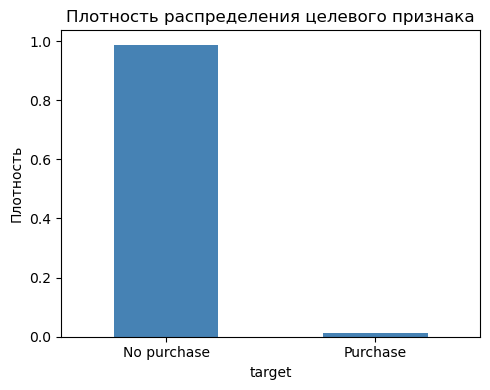

In [25]:
plt.figure(figsize=(5, 4))
y.value_counts(normalize=True).plot.bar(color='SteelBlue')
plt.ylabel('Плотность')
plt.title('Плотность распределения целевого признака')
plt.xticks([0, 1], ['No purchase', 'Purchase'], rotation=0)
plt.tight_layout()
plt.show()

### Кросс-валидация.

In [26]:
cross_validate(
    CatBoostClassifier(logging_level='Silent', random_state=RANDOM_STATE),
    X, y,
    n_jobs=-1,
    scoring=['roc_auc', 'recall', 'f1']
)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'fit_time': array([3.34967804, 3.22401309, 3.25792146, 3.2599318 , 2.73736596]),
 'score_time': array([0.01894736, 0.01994753, 0.01795363, 0.03589106, 0.00896478]),
 'test_roc_auc': array([0.96721311, 0.78688525, 0.36065574,        nan, 0.85      ]),
 'test_recall': array([0., 0., 0., 0., 0.]),
 'test_f1': array([0., 0., 0., 0., 0.])}

### Feature importance.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [28]:
catboost_model = CatBoostClassifier(logging_level='Silent', random_state=RANDOM_STATE)

In [29]:
catboost_model.fit(X_train, y_train)

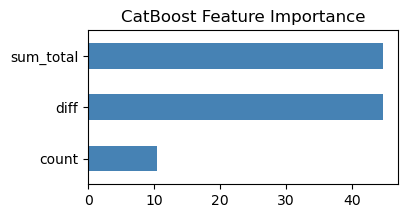

In [30]:
plt.figure(figsize=(4, 2))

pd.Series(
    index=catboost_model.feature_names_,
    data=catboost_model.feature_importances_
).sort_values().plot(kind='barh', color='SteelBlue')

plt.title('CatBoost Feature Importance')
plt.show()

### Производительность модели.

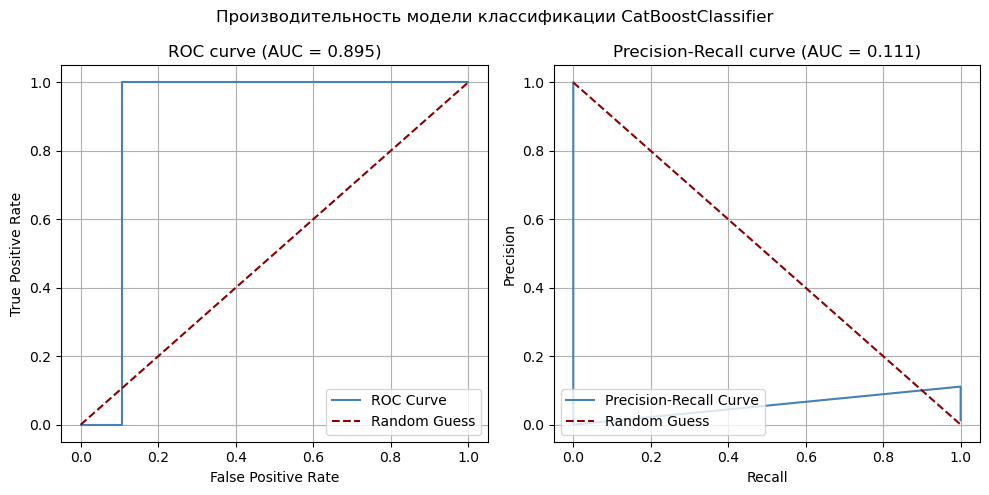

In [31]:
my_analyze_classification_performance(model=catboost_model, target=y_test, features=X_test)

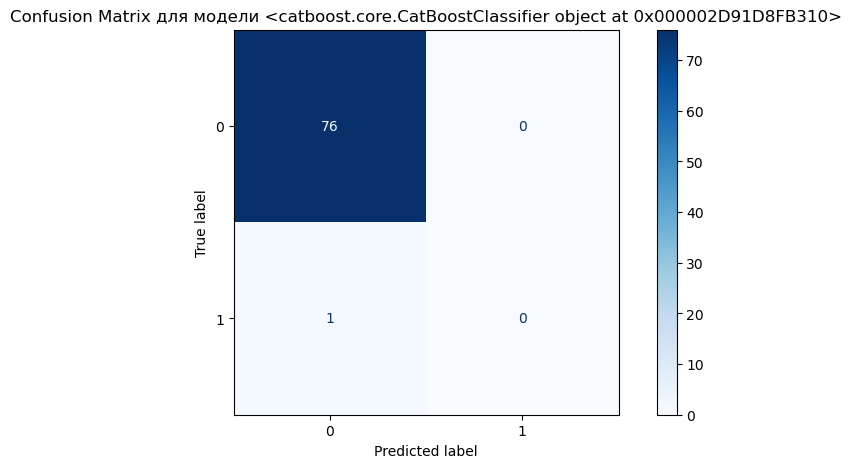

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    catboost_model.predict(X_test),
    cmap='Blues',
    ax=ax
)

ax.set_title(f'Confusion Matrix для модели {catboost_model}')
plt.show()